# Demo de modelos de Reservoir Computing (RC) para clasificar (atributo clase discreto) o estimar (atributo clase continuo) usando Serie Temporales.

Librerías disponibles:
- https://github.com/PlasmaControl/PyRCN  ->  https://pyrcn.readthedocs.io/en/latest/?badge=latest
- https://github.com/reservoirpy/reservoirpy  ->  https://reservoirpy.readthedocs.io/en/latest/?badge=latest

Más información en:  

- https://www.sciencedirect.com/science/article/abs/pii/S0952197622001713

- https://github.com/reservoirpy/awesome-reservoir-computing


# Preparación del Entorno:

In [1]:
#@title Instalar librería para RC
#@markdown Nota: antes de cambiar de libería, primero reinicie el entorno.
libreriaRC = "PyRCN" #@param ["PyRCN", "ReservoirPy"]

# controla que sean librerías implementadas
assert( (libreriaRC == "PyRCN") or (libreriaRC == "ReservoirPy") )


if libreriaRC == "PyRCN":
    # Fuerza actualizar scikit-learn
    !pip3 install -U scikit-learn
    # Instalar PyRCN y actualiza SKLearn
    !pip3 install -U pyrcn

elif libreriaRC == "ReservoirPy":
    # Instalar ReservoirPy
    !pip install reservoirpy
    # instala paquetes gráficos
    !apt-get install -y graphviz-dev
    !pip install pygraphviz



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.5/82.5 kB 2.4 MB/s eta 0:00:00


In [2]:
#@title Librerías a usar
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import csv

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output
import random

print("Librerías cargadas")

Librerías cargadas


# Datos:

In [3]:
#@title Acceder al Drive

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [4]:
#@title Cargar datos


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'ORO.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global Yori, Xori, nombre_clases

  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return

  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if attClase in att_entrada:
    print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
    att_entrada.remove( attClase )

  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return

  # guarda configuración
  nombre_clases = nomClases

    # genera los datos solo con los atributos seleccionados
  Yori = np.array(df[attClase])
  Xori = np.array(df[att_entrada])

  # muestra resultados
  print("\n> Atributos entrada: ", att_entrada)
  print("\t X: ", Xori.shape)

  if (nombre_clases is None) or (nombre_clases==""):
    print("\n> Atributo clase: ", attClase)
  else:
    print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
  print("\t Y: ", Yori.shape)

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())
print("\n")

# inicializa valores
Xori = None
Yori = None

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Aplicar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  ORO.csv  cargado

> Cabecera: 
   datetime_dia  datetime_mes  datetime_año  gold_price_usd
0            29            12          1978          137.06
1             1             1          1979          137.06
2             2             1          1979          137.29
3             3             1          1979          134.01
4             4             1          1979          136.79

> Características: 
       datetime_dia  datetime_mes  datetime_año  gold_price_usd
count  11151.000000  11151.000000  11151.000000    11151.000000
mean      15.725137      6.495830   1999.866200      576.028117
std        8.799768      3.441863     12.339642      384.936088
min        1.000000      1.000000   1978.000000      133.830000
25%        8.000000      4.000000   1989.000000      305.860000
50%       16.000000      7.000000   2000.000000      366.130000
75%       23.000000      9.000000   2011.000000      951.325000
max       31.000000     12.000000   2021.000000     1745.4

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo gold_price_usd como de entrada dado que es clase.

> Atributos entrada:  ['datetime_dia', 'datetime_mes', 'datetime_año']
	 X:  (11151, 3)

> Atributo clase:  gold_price_usd
	 Y:  (11151,)


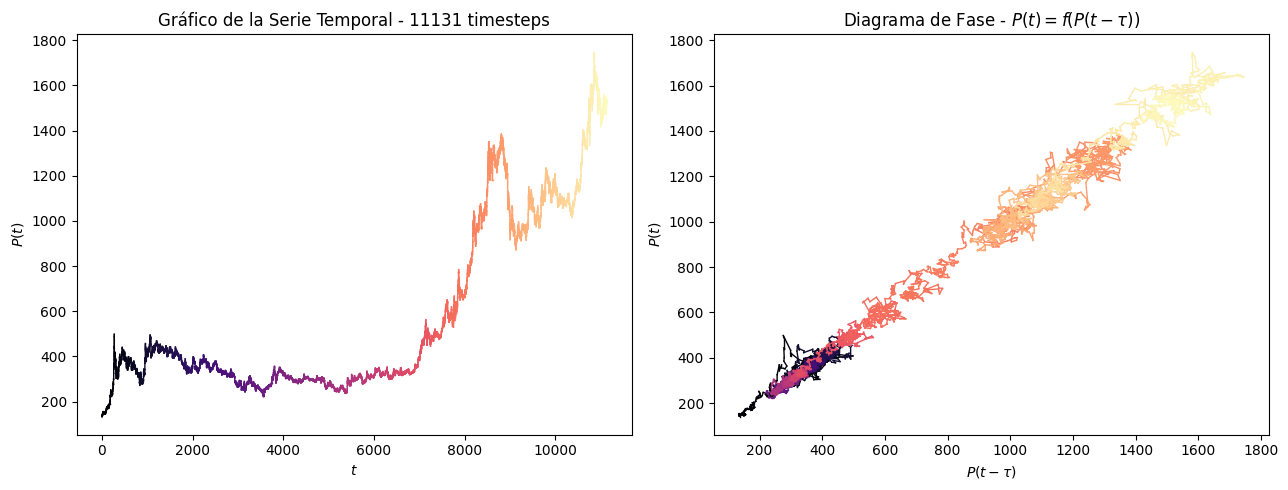

In [5]:
#@title Mostrar Gráfico de los datos cargados


# función auxiliar para graficar datos
def graficarSerieDatos(datosReal, datosModelo=None, titulo=""):
  if (datosReal is None) and (datosModelo is None):
    return
  legNames = []
  plt.figure(figsize=(15,8))
  if datosReal is not None:
    plt.plot(datosReal)
    legNames.append( "Real" )
  if datosModelo is not None:
    plt.plot(datosModelo)
    legNames.append( "Modelo" )
  if titulo != "":
    plt.title(titulo)

  plt.ylabel('valor Y')
  plt.xlabel('# ejemplo')
  if len(legNames) > 1:
    plt.legend(legNames, loc='upper left')
  plt.show()


def plot_with_Attractor(X, sample, tau):

    fig = plt.figure(figsize=(13, 5))
    N = sample

    ax = plt.subplot((121))
    t = np.linspace(0, N, N)
    for i in range(N-1):
        ax.plot(t[i:i+2], X[i:i+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Gráfico de la Serie Temporal - {N} timesteps")
    plt.xlabel("$t$")
    plt.ylabel("$P(t)$")

    ax2 = plt.subplot((122))
    ax2.margins(0.05)
    for i in range(N-1):
        ax2.plot(X[i:i+2], X[i+tau:i+tau+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Diagrama de Fase - $P(t) = f(P(t-\\tau))$")
    plt.xlabel("$P(t-\\tau)$")
    plt.ylabel("$P(t)$")

    plt.tight_layout()
    plt.show()


###graficarSerieDatos(datosReal=Yori,
##                   titulo="Gráfico de la Serie Temporal de los Datos Cargados")

diagFase_tau = 17 #@param{type:"integer"}

plot_with_Attractor(X=Yori, sample=len(Yori)-20, tau=diagFase_tau)

In [6]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = False #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(Xori[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler":
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler":
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler":
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler":
    scaler = preprocessing.RobustScaler()

  # normaliza los datos de entrada
  Xori = scaler.fit_transform(Xori)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(Xori[:10])

In [23]:
#@title Generar secuencia de datos como Serie

cantidad_intervalos_secuencia = 3 #@param {type:"integer"}

usar_atributos_secuencia = "Solo atributo a Estimar" #@param ["Solo atributo a Estimar", "Solo atributos de Entrada", "Todos"]

if cantidad_intervalos_secuencia < 1:
  cantidad_intervalos_secuencia = 1

# funciones auxilliares
def split_sequence(datosX, datosY, n_steps, atr_seq):
  x, y = [], []
  if len(datosX) != len(datosY):
    print("No coincide el largo de los datos X e Y!!!")
    return None, None
  for i in range(len(datosY)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(datosY)-1:
      break
    # gather input and output parts of the pattern
    if atr_seq == "Y":
      # sólo atributo a estimar (anteriores)
      seq_x = datosY[i:end_ix]
      seq_y = datosY[end_ix]
    elif atr_seq == "X":
      # sólo atributos de entrada (anteriores y actuales)
      seq_x = datosX[i:end_ix]
      seq_y = datosY[end_ix-1]
    else:
      # atributos de entrada y a estimar (anteriores)
      seq_xa = datosX[i:end_ix]
      seq_xb = datosY[i:end_ix]
      seq_y = datosY[end_ix]
      seq_x = []
      for xa, xb in zip(seq_xa, seq_xb):
        xa = list(xa)
        xa.append(xb)
        seq_x.append(xa)

    x.append( seq_x )
    y.append( seq_y )
  return np.array(x), np.array(y)

# muestra los primeros "cant" datos
def mostrarEjemplos(X, Y, cant=5):
  for i in range(min(len(X), cant)):
    print(X[i], Y[i])
  print("\n")

# define nombre atributos a considerar
def definirNombreAtributos(cantidad_intervalos_secuencia, inclX, inclY):
  auxAttList = []
  if not(inclY or inclX):
    inclY = True
  for i in range(cantidad_intervalos_secuencia):
    if cantidad_intervalos_secuencia > 1:
      auxiID = "#"+str(i+1)
    else:
      auxiID = ""
    if inclX:
      for at in list(combo_att_entrada.value):
        if str(at) != str(combo_att_clase.value):
          auxAttList.append( str(at) + auxiID )
    if inclY:
      auxAttList.append( str(combo_att_clase.value) + auxiID)
  return auxAttList

# procesa
print("\n> Antes de generar serie: ")
mostrarEjemplos(Xori, Yori)

# genera secuencias
auxAttList = []
print("> Generando series con ", cantidad_intervalos_secuencia ," intervalos ")
if (Xori.shape[1] == 0) or usar_atributos_secuencia == "Solo atributo a Estimar":
  atrSeq = "Y"
  cant_atributos_entrada = 1
  auxAttList = definirNombreAtributos(cantidad_intervalos_secuencia, inclX=False, inclY=True)
elif usar_atributos_secuencia == "Solo atributos de Entrada":
  atrSeq = "X"
  cant_atributos_entrada = Xori.shape[1]
  auxAttList = definirNombreAtributos(cantidad_intervalos_secuencia, inclX=True, inclY=False)
else: # "Todos"
  atrSeq = "XY"
  cant_atributos_entrada = Xori.shape[1] + 1
  auxAttList = definirNombreAtributos(cantidad_intervalos_secuencia, inclX=True, inclY=True)

X, Y = split_sequence(Xori, Yori, cantidad_intervalos_secuencia, atrSeq)



print("\n> Después de generar serie: ")
mostrarEjemplos(X, Y)
print(">Atributos de entrada: ", auxAttList)


> Antes de generar serie: 
[  29   12 1978] 137.06
[   1    1 1979] 137.06
[   2    1 1979] 137.29
[   3    1 1979] 134.01
[   4    1 1979] 136.79


> Generando series con  3  intervalos 

> Después de generar serie: 
[137.06 137.06 137.29] 134.01
[137.06 137.29 134.01] 136.79
[137.29 134.01 136.79] 138.35
[134.01 136.79 138.35] 136.38
[136.79 138.35 136.38] 137.29


>Atributos de entrada:  ['gold_price_usd#1', 'gold_price_usd#2', 'gold_price_usd#3']


In [24]:
#@title Preparar datos

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "continuo - ESTIMACION" #@param ["discreto - CLASIFICACION", "continuo - ESTIMACION"]

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# reshape de [cant ejemplos, datos entrada] into [cant ejemplos, intervalos, datos entrada]
X =  X.reshape((X.shape[0], cantidad_intervalos_secuencia, cant_atributos_entrada))

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y, shuffle=True)
  except ValueError:
    print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)

CLASES = []
if esProblemaClasificacion:
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases
  if (nombre_clases == "") or (nombre_clases == "-"):
      # toma los valores de clase orginales del archivo
      if str(Y[0]).replace(".","").isnumeric():
        # Y son numeros
        for val in range(int(np.max(Y))+1):
          CLASES.append( "clase {:>3}".format(val) )
      else:
          # Y no son números
          CLASES = list(set(Y))
          CLASES.sort()
          # cambia valores para que sean enteros
          y_train = [ CLASES.index(y) for y in y_train]
          y_test = [ CLASES.index(y) for y in y_test]
  else:
      # toma configuración de nombre de clases
      for val in nombre_clases.split(','):
        CLASES.append( val )

  # genera salida codificada para softMax
  y_trainEnc =  to_categorical(y_train)
  y_testEnc =  to_categorical(y_test)

  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES)
else:
  print("> se considera problema de ESTIMACIÓN \n")

  y_trainEnc = []
  y_testEnc =  []


print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, intervalos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_train:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, intervalos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_test:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)


> se considera problema de ESTIMACIÓN 


> Para Entrenamiento: 
 - x_train (cant ejemplos, intervalos, datos entrada):  (8361, 3, 1)
 - y_train (cant):  8361

 Para Prueba: 
 - x_test (cant ejemplos, intervalos, datos entrada):  (2787, 3, 1)
 - y_test (cant):  2787


# Modelo:

In [43]:
#@title Establecer modelo

# controla que sean librerías implementadas
assert( (libreriaRC == "PyRCN") or (libreriaRC == "ReservoirPy") )

# inicializa variables globales
ui_controls = {}
default_model_params = {}
model = None

# define clase auxiliar wapper
# para generar interface genérica
class modelWrapper(object):

    def __init__(self, libreriaRC, _modeloRCname, libreriaModel, cantAtributosEntrada=0, init_model_params={}):
      self._libreriaRC = libreriaRC
      self._modeloRCname = _modeloRCname
      self._modeloRC = libreriaModel
      self._cantInputAtt = cantAtributosEntrada
      self._init_model_params = init_model_params

    def display(self):
      print("Modelo " + self._modeloRCname + " [" + self._libreriaRC + "]:")
      if (self._libreriaRC == "PyRCN"):
        print("\n", self._modeloRC,"\n")
        display(self._modeloRC)
        print("")
      else:
        displayRPyModel(self._modeloRC)
        print("")

    def prepararX(self, x):
      if (self._cantInputAtt>0):
        return x.reshape(-1, self._cantInputAtt)
      else:
        return x

    def fit(self, x, y):
      # prepara datos
      xFit = self.prepararX(x)
      if libreriaRC == "ReservoirPy":
        yFit = y.reshape(-1, 1)
      else:
        yFit = y
      # entrena modelo
      if (self._libreriaRC == "PyRCN"):
          self._modeloRC.fit(X=xFit,
                             y=yFit)
      elif libreriaRC == "ReservoirPy":
          if ("warmup" in self._init_model_params) and (self._init_model_params["warmup"]>0):
            # controla que no supere el 10% de los datos
            warmup = min(len(xFit)/10, self._init_model_params["warmup"])
            print("--aplica warmup de ", warmup, "--")
            self._modeloRC.fit(X=xFit,
                              Y=yFit,
                              warmup=warmup)
          else:
            self._modeloRC.fit(X=xFit,
                              Y=yFit)
      return self._modeloRC

    def predict(self, x, verbose=0):
      # prepara datos
      xPredict = self.prepararX(x)
      # ejecuta modelo
      if (self._libreriaRC == "PyRCN"):
          y_pred = self._modeloRC.predict( xPredict )
      elif libreriaRC == "ReservoirPy":
        y_pred = self._modeloRC.run( xPredict, reset=True )
        print("")
      # formatea salida
      if len(y_pred)>0:
        return y_pred.reshape(-1, 1)
      else:
        return y_pred


# genera modelo dependiendo de la librería RC
if libreriaRC == "PyRCN":
    # para librería PyRCN
    import pyrcn
    import pyrcn.echo_state_network as esn
    import pyrcn.extreme_learning_machine as elm

    from pyrcn.base.blocks import BatchIntrinsicPlasticity
    from sklearn.pipeline import Pipeline, FeatureUnion
    from pyrcn.base.blocks import InputToNode, NodeToNode

    from pyrcn.linear_model import IncrementalRegression
    from sklearn.linear_model import Ridge as skRidge
    from sklearn.linear_model import LinearRegression as skLinearRegression

    # define parámetros por defecto para PyRCN
    default_model_params["tipoModelo"] = ('Tipo de Modelo:',
                                          ["Extreme Learning Machine", "Echo State Network" ])
    default_model_params["tipoRegressor"] = ('Tipo de Regressor:',
                                            ["skRidge", "skLinearRegression"]) # "Incremental Regression" no porque tira error
    default_model_params["input_activation"] = ('Función de activación para la capa input:',
                                                ["identity", "tanh", "logistic", "relu"])
    default_model_params["input_hidden_layer_size"] = ('Tamaño de la capa input:', 500)
    default_model_params["bias_scaling"] = ('Bias Scaling de la capa input:', 0.1)
    default_model_params["reservoir_activation"] = ('Función de activación para el reservoir:',
                                                    ["relu", "tanh", "logistic", "identity"])
    default_model_params["k_rec"] = ('Pesos recurrentes por nodo para el reservoir:', 100)
    default_model_params["leakage"] = ('Leakage Rate del reservoir:', 0.3,
                                      "Para menor leaking rate ->   high inertia, high recall of previous states, y para mayor -> low inertia, low recall of previous states")
    default_model_params["input_scaling"] = ('Input Scaling del reservoir:', 0.9)
    default_model_params["spectral_radius"] = ('Spectral Radius del reservoir:', 0.9,
                                               "Para menor spectral radius -> stable dynamics, y para mayor -> chaotic dynamics")
    default_model_params["alpha"] = ('Alpha del regressor:', 1e-3)
    default_model_params["random_state"] = 42
    default_model_params["bidirectional"] = False
    default_model_params["requires_sequence"] = False

    # función auxiliar para generar modelo PyRCN
    def create_pyrcn_model(tipoModelo, tipoRegressor,
                           attributesList, model_params):
        # determina inputs
        inputPipeLineList = []
        cantInput = 0
        for at in attributesList:
          cantInput += 1
          at = str(at)
          pl = Pipeline([('i_'+at,
                          InputToNode(hidden_layer_size=model_params["input_hidden_layer_size"],
                                      input_activation=model_params["input_activation"],
                                      bias_scaling=model_params["bias_scaling"])
                          )])
          inputPipeLineList.append( ('p_'+at, pl) )

        input_to_node = FeatureUnion(inputPipeLineList)
        node_to_model = NodeToNode(hidden_layer_size=model_params["input_hidden_layer_size"]*cantInput)

        # define tamaño capas ocultas
        model_params['hidden_layer_size'] = model_params["input_hidden_layer_size"]*cantInput

        # define regressor a usar
        tipoRegressor = str(tipoRegressor).lower()
        if (tipoRegressor =="sklinearregression"):
          regressor = skLinearRegression()
        elif (tipoRegressor =="skridge"):
          regressor = skRidge()
        elif (tipoRegressor =="incremental regression"):
          regressor = IncrementalRegression()
        else:
          regressor = None

        # define tipo modelo RC
        pyrcnModel = None
        tipoModelo = str(tipoModelo).lower()
        if (tipoModelo =="esn") or (tipoModelo =="echo state network"):
          # Echo State Network
          if esProblemaClasificacion:
            # modelo para clasificación
            pyrcnModel = esn.ESNClassifier(input_to_node=input_to_node,
                                           node_to_node=node_to_model,
                                           regressor=regressor,
                                           **model_params)

          else:
            # modelo para regresión/estimación
            pyrcnModel = esn.ESNRegressor(input_to_node=input_to_node,
                                          node_to_node=node_to_model,
                                          regressor=regressor,
                                          **model_params)

        elif (tipoModelo =="elm") or (tipoModelo =="extreme learning machine"):
          # Extreme Learning Machine
          if esProblemaClasificacion:
            # modelo para clasificación
            pyrcnModel = elm.ELMClassifier(input_to_node=input_to_node,
                                           node_to_node=node_to_model,
                                           regressor=regressor,
                                           **model_params)
          else:
            # modelo para regresión/estimación
            pyrcnModel = elm.ELMRegressor(input_to_node=input_to_node,
                                          node_to_node=node_to_model,
                                          regressor=regressor,
                                          **model_params)
        else:
          # Otro
          raise Exception("Tipo modelo " + str(tipoModelo) + " no soportado!")

        # devuelve el modelo creado
        return pyrcnModel, cantInput


elif libreriaRC == "ReservoirPy":
    # para librería ReservoirPy
    import reservoirpy
    import pygraphviz as pgv
    import tempfile
    from PIL import Image

    # define parámetros por defecto para ReservoirPy
    default_model_params["tipoModelo"] =  ('Tipo de Modelo:',
                                            ["Echo State Network"])
    default_model_params["reservoir_activation"] = ('Función de activación para el reservoir:',
                                                    ["relu", "softmax", "tanh", "sigmoid","identity"])
    default_model_params["connect_input_to_ouput"] = ('Conectar Entrada directo a la Salida:', False)
    default_model_params["cant_reservoirs"] = ('Cantidad de Reservoirs: ', 1)
    default_model_params["reservoir_connection"] = ('Forma de conexión entre reservoirs:',
                                                ["Paralela", "Secuencial"])
    default_model_params["reservoir_units"] = ('Cantidad de unidades por reservoir: ', 500)
    default_model_params["input_scaling"] = ('Input Scaling para los reservoirs: ', 1.0,
                                             "Para menor input scaling  ->  free running states, y para mayor -> high states vs inputs correlation (until saturation)")
    default_model_params["leaking_rate"] =  ('Leaking Rate de los reservoirs:', 0.3,
                                             "Para menor leaking rate ->   high inertia, high recall of previous states, y para mayor -> low inertia, low recall of previous states")
    default_model_params["spectral_radius"] = ('Spectral Radius de los reservoirs:', 0.9,
                                               "Para menor spectral radius -> stable dynamics, y para mayor -> chaotic dynamics")
    default_model_params["ridge"] = ('Regularization rate del ridge:', 1e-6)
    default_model_params["warmup"] = ('Warmup del modelo al entrenar:', 0,
                                      "Cantidad de ejemplos descartados al realizar el entrenamiento para que el modelo este estabilizado")
    default_model_params["seed"] = 42
    reservoirpy.set_seed( default_model_params["seed"] )

     # función auxiliar para generar modelo ReservoirPy
    def create_rPy_model(tipoModelo, attributesList, model_params):

        # define variables auxiliares
        cantInput = len(auxAttList)

        pyrcnModel = None
        tipoModelo = str(tipoModelo).lower()
        if (tipoModelo =="esn") or (tipoModelo =="echo state network"):
          # Echo State Network
          # entradas
          data = reservoirpy.nodes.Input(input_dim=cantInput)
          # reservoirs
          cant_reservoirs = max(1, model_params['cant_reservoirs'])
          conex_reservoirs_paralela = (model_params['reservoir_connection']=="Paralela")
          funcAct_reservoirs = reservoirpy.activationsfunc.get_function(
                                            model_params['reservoir_activation'] )
          reservoirListConnections = None
          reservoirList = None
          for i in range(cant_reservoirs):
            res = reservoirpy.nodes.Reservoir(units=model_params['reservoir_units'],
                                                    lr=model_params['leaking_rate'],
                                                    sr=model_params['spectral_radius'],
                                                    input_scaling=model_params['input_scaling'],
                                                    activation=funcAct_reservoirs,
                                                    seed=model_params["seed"])

            if conex_reservoirs_paralela:
                # reservoirs paralelos
                if reservoirList is None:
                  reservoirList = []
                reservoirList.append( res )
                if reservoirListConnections is None:
                  reservoirListConnections = res
                else:
                  reservoirListConnections = reservoirListConnections >> res
            else:
                # reservoirs secuenciales
                if reservoirList is None:
                  reservoirList = res
                else:
                  reservoirList = reservoirList >> res
                # determina si tiene que agregar ridge auxiliar de conexión
                if (i+1) < cant_reservoirs:
                  res_out = reservoirpy.nodes.Ridge(ridge=model_params['ridge'])
                  reservoirList = reservoirList >> res_out

          # salida
          readout = reservoirpy.nodes.Ridge(output_dim=1,
                                            ridge=model_params['ridge'])
          # conexiones
          if model_params['connect_input_to_ouput']:
              rPy_model = [data, data >> reservoirList] >> readout
          else:
              rPy_model = data >> reservoirList >> readout

          if  (reservoirListConnections is not None):
            rPy_model =  reservoirListConnections & \
                              rPy_model

        else:
          # Otro
          raise Exception("Tipo modelo " + str(tipoModelo) + " no soportado!")

        # devuelve el modelo creado
        return rPy_model, cantInput


    # función para mostrar el modelo
    def displayRPyModel(rPy_model):

        ## muestra modelo texto
        print(" > ", rPy_model.name, ":")
        for n in rPy_model.nodes:
          print("\t - ",  n)

        ## genera edges para gráfico
        print("")
        graph_edges = {}
        for e in rPy_model.edges:
          ##print(e[0].name, "->", e[1].name)
          if e[0].name not in graph_edges:
            graph_edges[e[0].name] = {}
          graph_edges[e[0].name][e[1].name] = None

        ## elimina los 'concat'
        graph_edges_trim = {}
        for k in graph_edges.keys():
          if "Concat" not in k:
            graph_edges_trim[k] = {}
            for v in graph_edges[k]:
              if "Concat"  in v:
                for cv in graph_edges[v]:
                  graph_edges_trim[k][cv] = None
              else:
                graph_edges_trim[k][v] = None


        # genera gráfico y muestra
        g = pgv.AGraph(graph_edges_trim, strict=False, directed=True)
        g.graph_attr['label']='' # título
        g.graph_attr['ranksep']='0.6' # separación entre niveles
        g.graph_attr['nodesep']='1' # separación en el mismo nivel

        g.graph_attr['label']=''
        g.node_attr['shape']='box'
        g.node_attr['color']='blue'
        g.edge_attr['color']='indigo'
        g.layout(prog="dot")

        auxFile = tempfile.NamedTemporaryFile(suffix=".png")
        g.draw(auxFile.name,format="png")
        display(Image.open(auxFile.name))


# función auxiliar para que no ejecute UI cada vez
def hacerNada():
  return


# crea interface para configuración
def crearUI(libreriaRC, default_parms):
    global ui_controls
    ui_controls = {}

    # titulo librería
    ui_controls["label_libreria"] = widgets.Label(
      value="> Librería " + str(libreriaRC) + ":",
      style=style_3D,
      disabled=False
    )
    # recorre la lista de parámetros y muestra lo controles
    # (definidos como tuplas)
    for k in default_parms.keys():
      if isinstance(default_parms[k], tuple):
        # muestra widget para configuración
        desc = default_parms[k][0]
        vals = default_parms[k][1]
        if len(default_parms[k])>2:
          tip = default_parms[k][2]
        else:
          tip = desc
        if isinstance(vals, list):
            # genera combo
            ui_controls[k] = widgets.Dropdown(
              options=vals,
              value=vals[0],
              description=desc,
              style=style_3D,
              disabled=False,
              tooltip = tip,
              layout=Layout(width='auto', height='auto')
            )
        elif isinstance(vals, bool):
            # genera checkbox
            ui_controls[k] = widgets.Checkbox(
              value=vals,
              description=desc,
              style=style_3D,
              disabled=False,
              tooltip = tip,
              layout=Layout(width='auto', height='auto')
            )
        elif isinstance(vals, int):
            # genera BoundedIntText
            ui_controls[k] = widgets.BoundedIntText(
              value=vals,
              min=(0 if vals<1 else 1),
              max=1000,
              step=1,
              description=desc,
              style=style_3D,
              disabled=False,
              tooltip = tip,
              layout=Layout(width='auto', height='auto')
            )
        elif isinstance(vals, float) or isinstance(vals, complex):
            # genera BoundedIntText
            ui_controls[k] = widgets.BoundedFloatText(
              value=vals,
              min=(0.0 if vals<1 else 1.0),
              max=10.0,
              step=0.01,
              description=desc,
              style=style_3D,
              disabled=False,
              tooltip = tip,
              layout=Layout(width='auto', height='auto')
            )
        else:
            # por defecto genera Text
            ui_controls[k] = widgets.Text(
              value=vals,
              description=desc,
              style=style_3D,
              disabled=False,
              tooltip = tip,
              layout=Layout(width='auto', height='auto')
            )

    # prepara botón y grilla con objetos
    btnAplicarModelo = widgets.Button(
        description='Aplicar'
    )
    btnAplicarModelo.on_click(on_btnAplicarModelo_clicked)
    ui_controls["btnAplicarModelo"] =  btnAplicarModelo

    # output
    out_config = widgets.interactive_output(hacerNada, {})
    ui_controls["out_config"] =  out_config

    # grilla
    configDatos_ui = widgets.GridBox(
          children=list(ui_controls.values()),
          layout=Layout(width='100%')  )
    display(configDatos_ui)

    # ejecuta para que muestre
    on_btnAplicarModelo_clicked(btnAplicarModelo)


# se define esta función para que se ocupe de aplicar la configuración
def on_btnAplicarModelo_clicked(b):
    global ui_controls, model, auxAttList
    global default_model_params
    ui_controls["out_config"].clear_output()
    with ui_controls["out_config"]:
        print("")
        # define parametos iniciales para modelo
        init_model_params = {}
        for kParam in default_model_params.keys():
          if kParam in ui_controls:
            # usa el valor configurado por el usuario
            init_model_params[kParam] = ui_controls[kParam].value
          else:
            # usa el valor por defecto
            init_model_params[kParam] = default_model_params[kParam]
        if (libreriaRC == "PyRCN"):
            # crea modelo PyRCN
            libraryModel, cantInput  = create_pyrcn_model(init_model_params["tipoModelo"],
                                                        init_model_params["tipoRegressor"],
                                                        auxAttList,
                                                        init_model_params)
        elif libreriaRC == "ReservoirPy":
            # crea modelo ReservoirPy
            libraryModel, cantInput  = create_rPy_model(init_model_params["tipoModelo"],
                                                        auxAttList,
                                                        init_model_params)
        # agrega el modelo al wrapper
        model = modelWrapper(libreriaRC, init_model_params["tipoModelo"],
                            libraryModel, cantInput, init_model_params)
        # muestra modelo creado
        model.display()


# crea interface
crearUI(libreriaRC, default_model_params)


GridBox(children=(Label(value='> Librería PyRCN:', style=DescriptionStyle(description_width='initial')), Dropd…

In [44]:
#@title Entrenar

optimizar_hiperparámetros = False #@param {type:"boolean"}
optimizar_hiperparámetros_maxEvals = 50 #@param {type:"integer"}
optimizar_hiperparámetros_maxEvals = int(max(10, optimizar_hiperparámetros_maxEvals))

# entrena
print("\n\n>Comienza el Entrenamiento:")
if optimizar_hiperparámetros:

    # controla que sean librerías implementadas
    assert( (libreriaRC == "PyRCN") or (libreriaRC == "ReservoirPy") )

    # genera modelo dependiendo de la librería RC
    if libreriaRC == "PyRCN":
        # para librería PyRCN
        from sklearn.metrics import make_scorer
        from sklearn.metrics import mean_squared_error
        from sklearn.model_selection import TimeSeriesSplit
        from sklearn.model_selection import (RandomizedSearchCV,
                                            GridSearchCV)
        from scipy.stats import uniform, loguniform
        from pyrcn.model_selection import SequentialSearchCV
        # parámetros generales
        verboseParamValue = 5
        scorer = make_scorer(mean_squared_error, greater_is_better=False)
        # 1ra serie de parámetros
        step_1_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                        'spectral_radius': uniform(loc=0, scale=2)}
        n_iter_1 = int(max(20, optimizar_hiperparámetros_maxEvals*3//4))
        kwargs_1 = {'verbose': verboseParamValue,'n_iter': n_iter_1, 'scoring': scorer,
                    'n_jobs': -1, 'random_state': 42, 'cv': TimeSeriesSplit()}
        # 2da serie de parámetros
        step_2_params = {'leakage': [0.2, 0.4, 0.7, 0.9, 1.0]}
        kwargs_2 = {'verbose': verboseParamValue, 'scoring': scorer,
                    'n_jobs': -1, 'cv': TimeSeriesSplit()}
        # 3ra serie de parámetros
        step_3_params = {'bias_scaling': np.linspace(0.0, 1.0, num=11)}
        kwargs_3 = {'verbose': verboseParamValue, 'scoring': scorer,
                    'n_jobs': -1, 'cv': TimeSeriesSplit()}
        # 4ta serie de parámetros
        step_4_params =  {'alpha': loguniform(1e-5, 1e-1)}
        n_iter_4 = int(max(5, optimizar_hiperparámetros_maxEvals-n_iter_1))
        kwargs_4 = {'verbose': verboseParamValue, 'n_iter': 50, 'scoring': scorer,
                    'n_jobs': -1, 'random_state': 42, 'cv': TimeSeriesSplit()}
        # define búsquedas
        searches = [('(1) input_scaling & spectral_radius', RandomizedSearchCV, step_1_params, kwargs_1),
                    ('(2) leakage', GridSearchCV, step_2_params, kwargs_2),
                    ('(3) bias_scaling', GridSearchCV, step_3_params, kwargs_3),
                    ('(4) alpha', RandomizedSearchCV, step_4_params, kwargs_4)]
        # entrenamiento con optimización del modelo
        print("\n\t - Optimizando hiper-parámetros:  ")
        for s in searches:
          print("\t\t\t", s[0], ":", s[1], s[2])
        print("")
        # prepara datos
        model_opt = SequentialSearchCV(model._modeloRC,
                                      searches)\
                                    .fit(model.prepararX(x_train), y_train)
        # asigna mejor modelo encontrado
        model._modeloRC = model_opt.best_estimator_
        # lo muestra
        print("")
        model.display()

    elif libreriaRC == "ReservoirPy":
      # para librería ReservoirPy
      from reservoirpy.observables import nrmse, rsquare
      from reservoirpy.hyper import research
      import json
      import random

      # función auxiliar para generar modelo ReservoirPy de prueba
      def try_reserach_rPy_model(x_train, y_train, input_scaling, spectral_radius, leaking_rate, ridge, warmup):
        global model, auxAttList
        # genera una copia de init_model_params
        # para cambiar las variables probadas como hiper-parámetros
        obj_model_param = model._init_model_params.copy()
        obj_model_param["input_scaling"] = input_scaling
        obj_model_param["leaking_rate"] =  leaking_rate
        obj_model_param["spectral_radius"] = spectral_radius
        obj_model_param["ridge"] = ridge
        # controla que no supere el 10% de los datos
        warmup = min(len(x_train)/10, warmup)
        obj_model_param["warmup"] = warmup
        # crea el modelo con los parámetros
        rPy_model, _  = create_rPy_model(obj_model_param["tipoModelo"],
                                            auxAttList,
                                            obj_model_param)

        # entrena el modelo
        rPy_model.fit(x_train, y_train, warmup=warmup)
        return rPy_model, obj_model_param

      # Objective functions accepted by ReservoirPy must respect some conventions:
      #  - dataset and config arguments are mandatory, like the empty '*' expression.
      #  - all parameters that will be used during the search must be placed after the *.
      #  - the function must return a dict with at least a 'loss' key containing the result of the loss function.
      # You can add any additional metrics or information with other keys in the dict. See hyperopt documentation for more informations.
      def objective_rPy(dataset, config, *, input_scaling, spectral_radius, leaking_rate, ridge, warmup, seed):

          # obbtiene los datos del dataset
          # (ya están preparados para la librería)
          x_train, y_train, x_test, y_test = dataset

          # Build your model given the input parameters and train it
          rPy_model, _ = try_reserach_rPy_model(x_train, y_train,
                                          input_scaling, spectral_radius,
                                          leaking_rate, ridge, warmup)
          # test model
          preds = rPy_model.run(x_test)
          # caluculate metrics
          loss = nrmse(y_test, preds, norm_value=np.ptp(x_train))
          r2 = rsquare(y_test, preds)

          # Return a dictionnary of metrics. The 'loss' key is mandatory when using hyperopt.
          return {'loss': loss,
                  'r2': r2}

      # define the research space
      # con los rangos de hiperparámetros a probar
      hyperopt_config_rPy = {
          "exp": "hyperopt-multiscroll",    # the experimentation name
          "hp_max_evals": int(optimizar_hiperparámetros_maxEvals),  # the number of differents sets of parameters hyperopt has to try
          "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
          "seed": int(model._init_model_params['seed']), # the random state seed, to ensure reproducibility
          "hp_space": {                     # what are the ranges of parameters explored
              "spectral_radius": ["loguniform", 1e-5, 2],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
              "leaking_rate": ["loguniform", 1e-5, 1],    # idem with the leaking rate, from 1e-3 to 1
              "input_scaling": ["uniform", 1e-5, 1], # the input  from 1e-3 to 1
              "ridge": ["uniform", 1e-8, 1],        # and so is the regularization parameter.
              "warmup": ["randint", 0, 25],
              "seed" : ["choice", int(model._init_model_params['seed'])]
          }
      }
      print("\n\t - Optimizando hiper-parámetros:  ")
      for k in hyperopt_config_rPy.keys():
        if k == "hp_space":
          for k2 in hyperopt_config_rPy[k].keys():
            print("\t\t\t", k2, ":", hyperopt_config_rPy[k][k2])
        else:
          print("\t\t\t", k, ":", hyperopt_config_rPy[k])
      print("")

      # we precautionously save the configuration in a JSON file
      # each file will begin with a number corresponding to the current experimentation run number.
      with open(f"{hyperopt_config_rPy['exp']}.config.json", "w+") as f:
          json.dump(hyperopt_config_rPy, f)

      # prepare the data
      dataset_rPy = (model.prepararX(x_train),
                 y_train.reshape(-1, 1),
                 model.prepararX(x_test),
                 y_test.reshape(-1, 1))

      # ejecuta la búsqueda de hiper-parámetros
      best_try = research(objective_rPy, dataset_rPy, f"{hyperopt_config_rPy['exp']}.config.json", ".")
      best_params = best_try[0]
      print("\n-- Mejor resultado: ")
      for k in best_params.keys():
        print("\t --",k, ":", best_params[k])
      print("")

      # genera el mejor modelo y agrega al al wrapper
      best_model_rPy, best_model_params = try_reserach_rPy_model(dataset_rPy[0], dataset_rPy[1],
                                              best_params["input_scaling"],
                                               best_params["spectral_radius"],
                                               best_params["leaking_rate"],
                                               best_params["ridge"],
                                               best_params["warmup"])
      model._modeloRC = best_model_rPy
      model._init_model_params = best_model_params
      # muestra modelo creado
      model.display()

else:

    # entrenamiento normal
    model.fit(x_train, y_train)

print("\n>Entrenamiento Finalizado.")




>Comienza el Entrenamiento:


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use 


>Entrenamiento Finalizado.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.39072e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


*** Resultados con datos de Entrenamiento: 



 Error Absoluto: 
            Mínimo: 0.0005 
            Promedio: 4.2721 ± 5.8802
            Máximo: 106.9026 


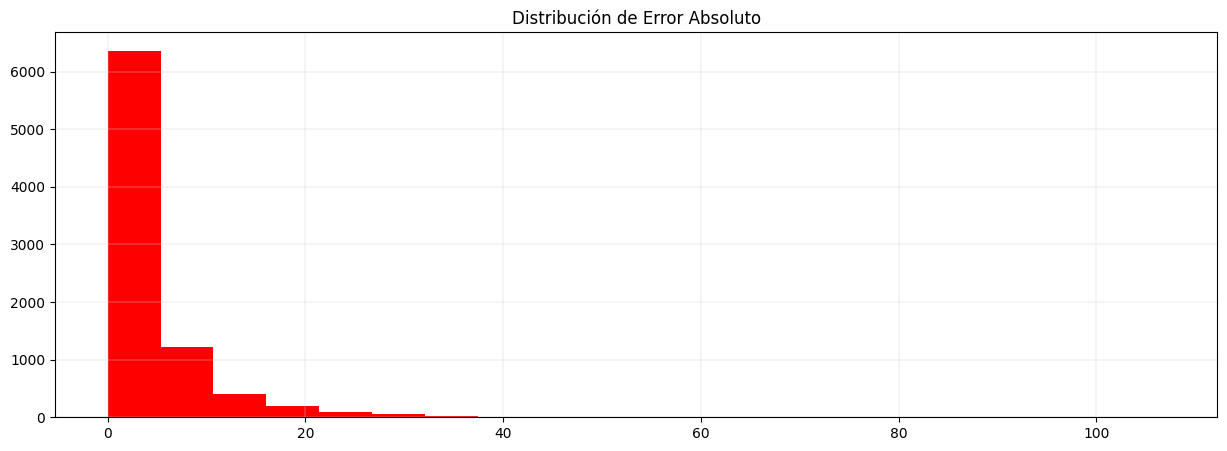


 Error Relativo: 
            Mínimo: 0.00% 
            Promedio: 0.77 ± 0.86
            Máximo: 14.74% 


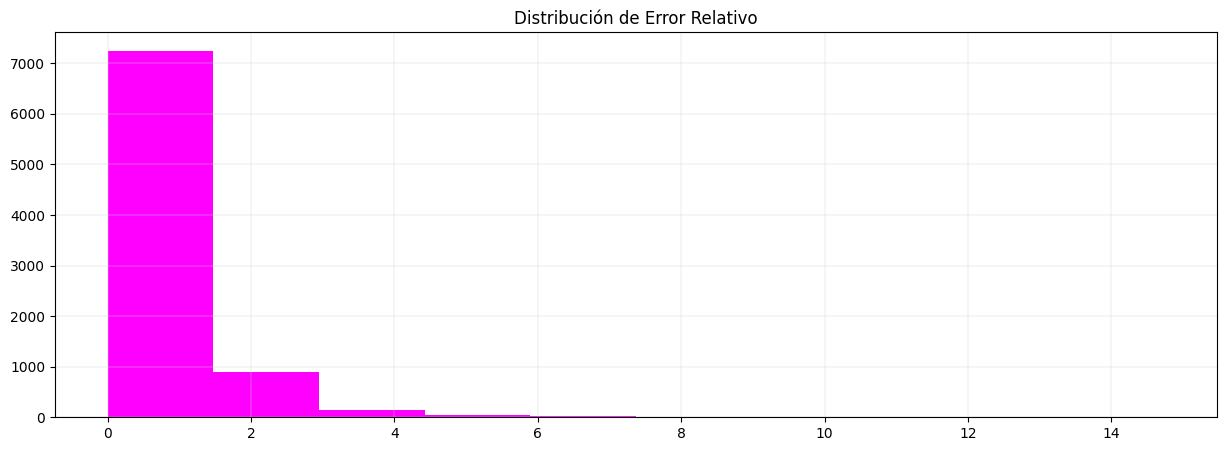

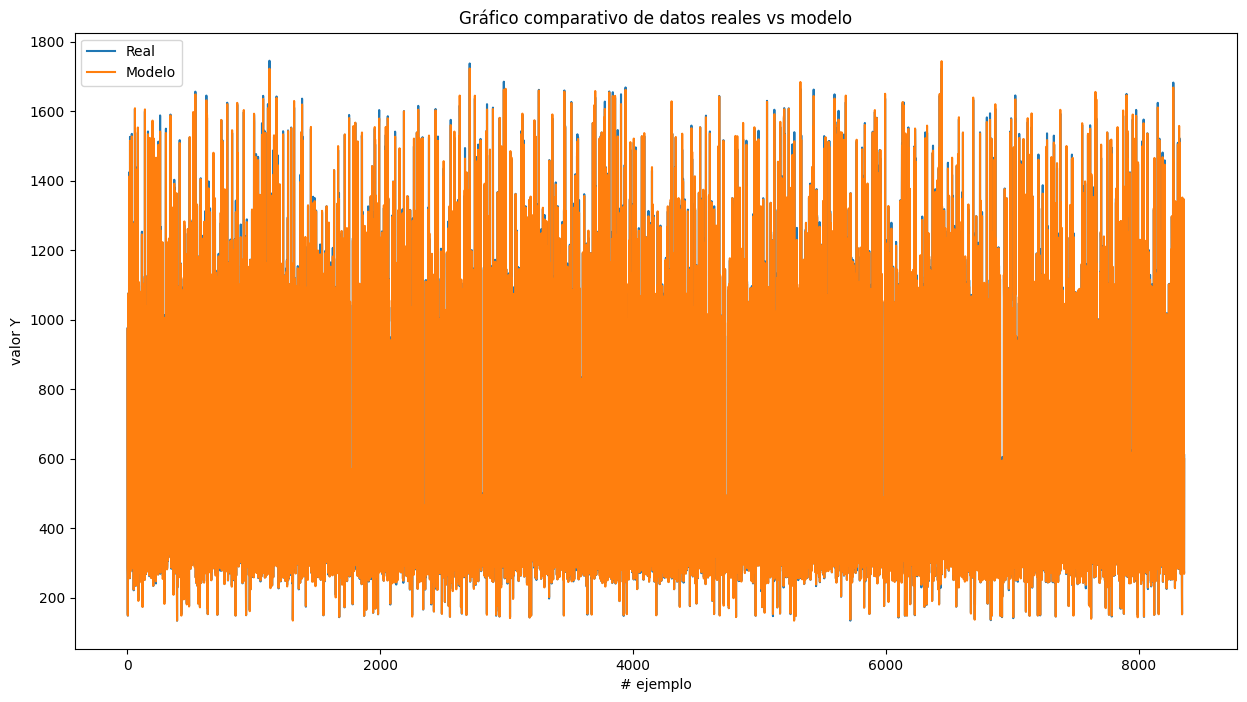

In [45]:
#@title Evaluar red entrenada con datos de entrenamiento

umbral_clasificacion = 50 # param {type:"slider", min:1, max:99, step:1}
mostrar_detalle_entrenamiento = False #@param {type:"boolean"}
incluirDatosEntrada_detalle_entrenamiento = False #@param {type:"boolean"}

tipo_output_softMax = False

# función auxiliar para el cálculo de error
def calcErrores(datos, pred, real, mostrarDetalle=False, inclDatosEntrada=False):
  arAbs = []
  arRel = []

  if mostrarDetalle:
    if inclDatosEntrada:
      print(" Datos ->", end="")
    print(" Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]")

  for x, pV, r in zip(datos, pred, real):
    # toma el valor estimado/predecido
    p = pV[0]
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)

      if mostrarDetalle:
        if inclDatosEntrada:
          print(" " + str(x) + "->", end="")
        print(" R: {:>8.4f} / M: {:>8.4f} [ {:>8.4f} | {:>8.2f}% ]".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5))
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Estimacion(x, y, detalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    estimVals = model.predict(x, verbose=0)

    # llama a la función
    arAbs, arRel = calcErrores(x, estimVals, y, detalle, inclDatosEntrada)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.4f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.4f} ± {:.4f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.4f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")

    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")

    # muestra grafico
    graficarSerieDatos(datosReal=y,
                      datosModelo=estimVals,
                      titulo="Gráfico comparativo de datos reales vs modelo")


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Clasificacion(x, y, clases_map, umbralClas = 0.5, mostrarDetalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    predClass = model.predict(x, verbose=0)

    if mostrarDetalle:
      if inclDatosEntrada:
        print("  Datos Entrada -> Clase Real / Clase Modelo -> Resultado")
      else:
        print(" Clase Real / Clase Modelo -> Resultado")

    # muestra los resultados con las imágenes
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ int(y[i]) ]

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>umbralClas and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE INVÁLIDA"
        else:
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = "  "
        if inclDatosEntrada:
          strTitulo = strTitulo + str(x[i]) + '-> '
        strTitulo = strTitulo + 'R: ' + str(clReal) + ' [' + str(y[i]) + '] '
        strTitulo = strTitulo + ' / M: ' + str(clPred) + ' ' + str(predClass[i]) + ' '
        strTitulo = strTitulo + "-> " + ("OK" if (clPred==clReal) else "ERROR!")

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)


    # genera lista de labels
    labels_clases_map =  list(set(classReal + classPreds))
    labels_clases_map.sort()

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds, zero_division=0))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=labels_clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in labels_clases_map],
        columns=['m:{:}'.format(x) for x in labels_clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    #cmtx.sort_index(axis=0, inplace=True)
    #cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")

    # gráfico de comparación
    dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=labels_clases_map)
    fig, ax = plt.subplots(figsize=(15,5))
    dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
    dispCM.ax_.set_title('Gráfico de Confusión:')
    dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
    plt.tight_layout()
    plt.show()


# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_train, y_train, CLASES, umbral_clasificacion/100.0, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)
else:
  probarModelo_Estimacion(x_train, y_train, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)




*** Resultados con datos de Prueba: 
 Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]
 R: 1363.3600 / M: 1349.5350 [  13.8250 |     1.01% ]
 R: 300.4300 / M: 300.1725 [   0.2575 |     0.09% ]
 R: 293.7600 / M: 294.7128 [   0.9528 |     0.32% ]
 R: 287.9700 / M: 285.9196 [   2.0504 |     0.71% ]
 R: 1096.5200 / M: 1086.4356 [  10.0844 |     0.92% ]
 R: 436.6300 / M: 439.9058 [   3.2758 |     0.75% ]
 R: 1353.1000 / M: 1350.7124 [   2.3876 |     0.18% ]
 R: 310.7000 / M: 310.6245 [   0.0755 |     0.02% ]
 R: 257.8400 / M: 259.5667 [   1.7267 |     0.67% ]
 R: 297.3300 / M: 297.8139 [   0.4839 |     0.16% ]
 R: 266.2300 / M: 267.0942 [   0.8642 |     0.32% ]
 R: 440.8300 / M: 442.1507 [   1.3207 |     0.30% ]
 R: 361.0500 / M: 361.1612 [   0.1112 |     0.03% ]
 R: 373.3700 / M: 392.1702 [  18.8002 |     5.04% ]
 R: 301.5500 / M: 303.3172 [   1.7672 |     0.59% ]
 R: 307.3400 / M: 307.0115 [   0.3285 |     0.11% ]
 R: 278.1600 / M: 278.2340 [   0.0740 |     0.03% ]
 R: 149.

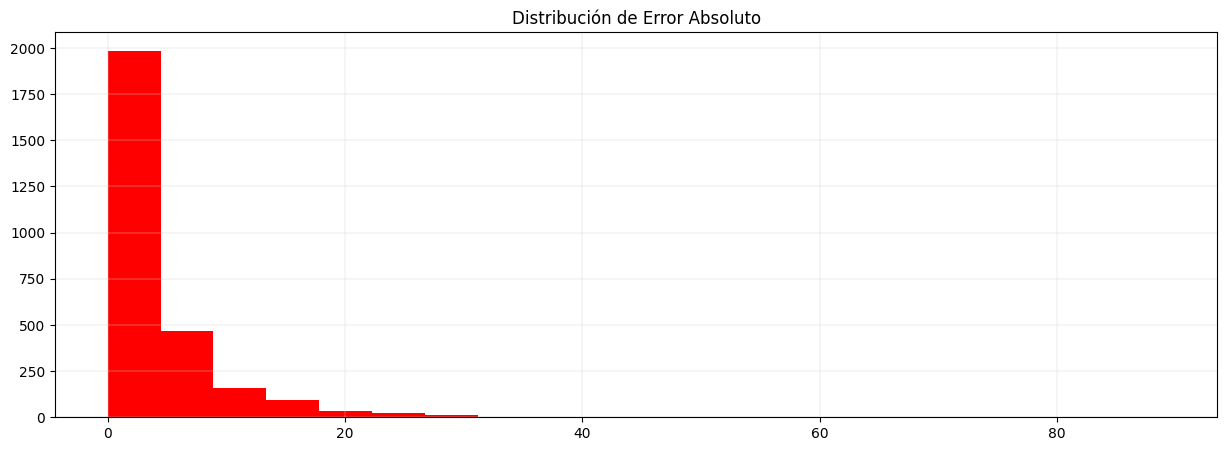


 Error Relativo: 
            Mínimo: 0.00% 
            Promedio: 0.77 ± 0.91
            Máximo: 13.12% 


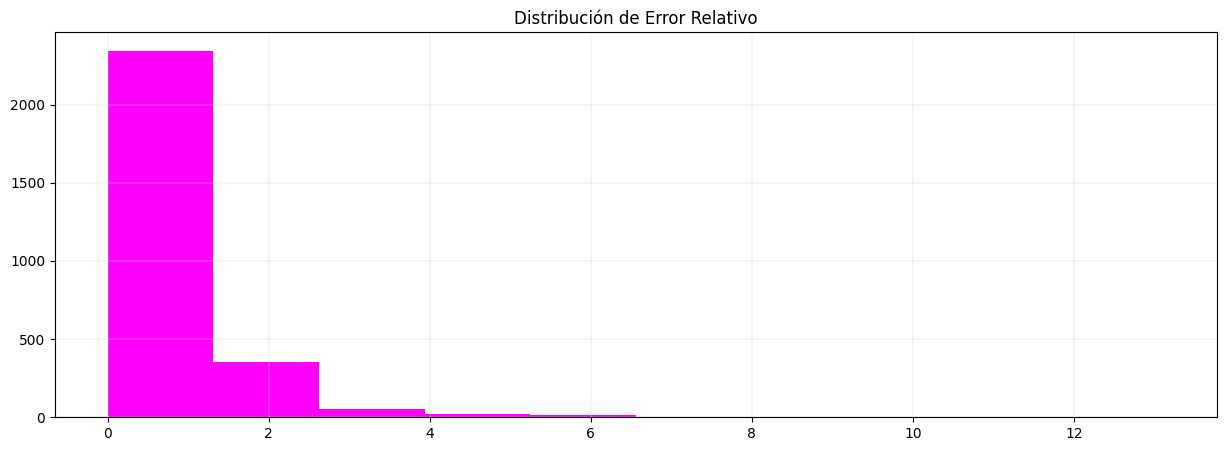

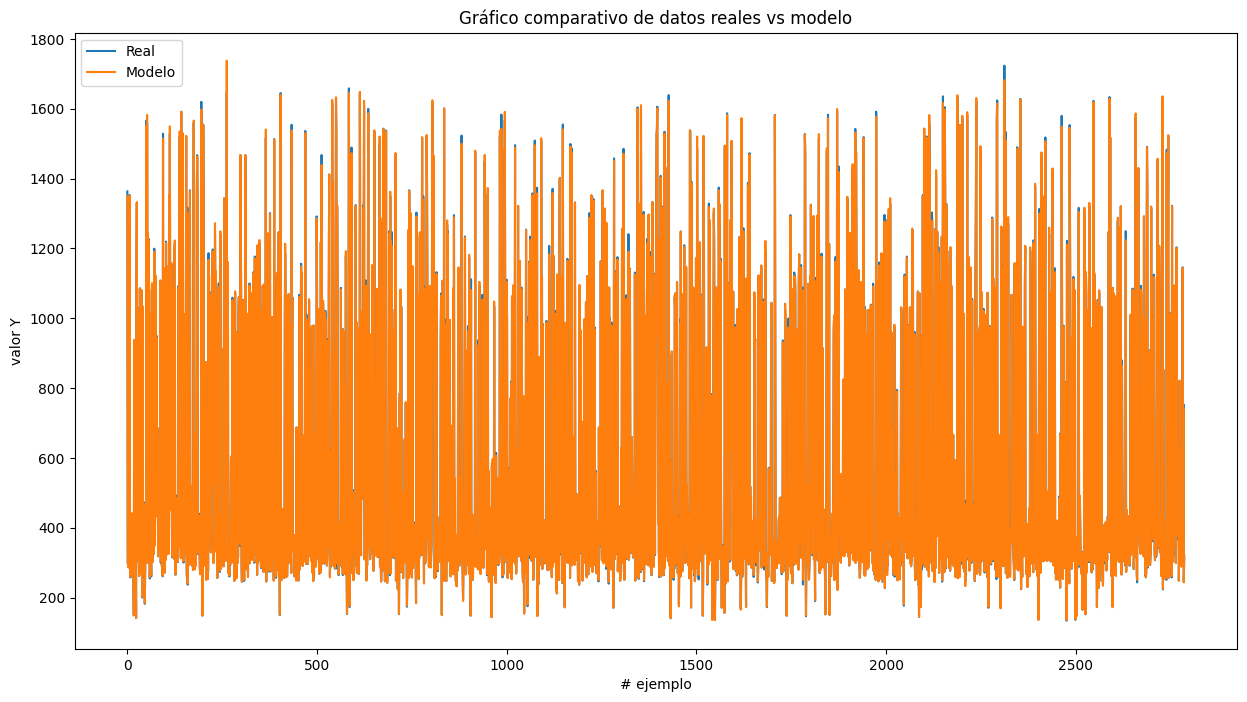

In [46]:
#@title Evaluar red entrenada con datos de prueba
mostrar_detalle_prueba = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_prueba = False #@param {type:"boolean"}

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_test, y_test, CLASES, umbral_clasificacion/100.0, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)
else:
  probarModelo_Estimacion(x_test, y_test, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)


In [47]:
#@title Guardar Modelo entrenado

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoML/modelos/datosRC'  #@param {type:"string"}

if guardar_modelo:


    import joblib
    import os

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_modelo = path_modelo + "/RC.joblib"
    joblib.dump(model, fn_modelo)
    print("\n-Modelo guardado en ", fn_modelo,"\n")

    if ("scaler" in locals()) and (scaler is not None):
      fn_scaler = path_modelo+"/SCALER.joblib"

      joblib.dump(scaler, fn_scaler)
      print("\n-SCALER para normalizar datos de entrada guardado en ", fn_scaler,"\n")

    if ("CLASES" in locals()) and (CLASES is not None):
      fn_clases = path_modelo+"/CLASES_MAP.txt"
      with open(fn_clases, 'w') as f:
        for i in range(len(CLASES)):
          f.write(str(i)+":"+str(CLASES[i])+"\n")
      print("\n-CLASES_MAP para mostrar los resultados guardado en ", fn_clases,"\n")

else:
    print("\n-Modelo no guardado.")


-Modelo guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/datosRC/RC.joblib 


-CLASES_MAP para mostrar los resultados guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/datosRC/CLASES_MAP.txt 

